# Induktive Statistik & Gruppenvergleiche

**Ziel dieses Notebooks:**

Bisher haben wir die Daten nur beschrieben (Deskriptive Statistik). Wir haben Unterschiede gesehen, wissen aber nicht, ob diese "echt" sind oder nur durch Zufall in unserer Stichprobe entstanden sind. 

Wir wissen nun zum Beispiel, dass der Mittelwert für "Sicherheitsgefühl" bei einem bestimmten Wert liegt. Aber ist dieser Wert verlässlich? Unterscheiden sich Länder mit hoher Kriminalität wirklich signifikant von solchen mit niedriger Kriminalität?

Um das zu beantworten, wenden wir, in diesem Notebook, Methoden der Inferenzstatistik (Vorlesungen 5 bis 9) an, um Hypothesen statistisch zu prüfen. Wir konzentrieren uns dabei besonders auf die Variable "Feeling safe at night" und untersuchen, welche Faktoren dieses Sicherheitsgefühl signifikant beeinflussen.

Da unser Datensatz aus aggregierten Länderindizes besteht (und nicht aus Rohdaten einzelner befragter Personen), wenden wir keine diskreten Wahrscheinlichkeitsmodelle (z.B. Urnenmodelle, kombinatorische Wahrscheinlichkeit) an. Stattdessen modellieren wir die Variablen als stetige Verteilungen (Normalverteilungsannahme), um Aussagen über Wahrscheinlichkeiten von Merkmalsausprägungen zu treffen.

## 1. Setup & Daten Laden

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pathlib import Path

In [22]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Daten laden & Pivotisieren

Wir nutzen den *Snapshot-Datensatz*, da Hypothesentests unabhängige Beobachtungen erfordern. Zeitreihendaten würden durch die Wiederholung der Länder (Autokorrelation) die p-Werte verfälschen (Pseudoreplikation). Der Snapshot-Datensatz enthält jedes Land genau einmal. Das garantiert die Unabhängigkeit der Datenpunkte.

In [23]:
# Daten laden 
try:
    df_raw = pd.read_csv('../data/oecd_snapshot_latest.csv')
    print("Snapshot-Datensatz erfolgreich geladen.")
except FileNotFoundError:
    try: 
        df_raw = pd.read_csv('data/oecd_snapshot_latest.csv')
        print("Snapshot-Datensatz (Fallback) geladen.")
    except FileNotFoundError:
        print("FEHLER: Datei nicht gefunden. Bitte Pfad prüfen.")


safety_df = df_raw[df_raw['measure'] == 'Feeling safe at night'].copy()

print("\nVerfügbare Aufschlüsselungen (Sex):", safety_df['sex'].unique())
print("Verfügbare Aufschlüsselungen (Education):", safety_df['education_level'].unique())

Snapshot-Datensatz erfolgreich geladen.

Verfügbare Aufschlüsselungen (Sex): ['Total' 'Male' 'Female']
Verfügbare Aufschlüsselungen (Education): ['Tertiary education' 'Total' 'Primary education' 'Secondary education']


Unser Datensatz liegt im "Long Format" vor (eine Zeile pro Messwert). Für statistische Tests, die Zusammenhänge zwischen verschiedenen Variablen prüfen (z.B. Sicherheit vs. Mordrate), brauchen wir das "Wide Format" (eine Zeile pro Land, Variablen als Spalten).

In [24]:
# Wir filtern auf die Gesamtbevölkerung ('Total'), um nur EINEN Wert pro Land und Indikator zu haben.
df_filtered = df_raw[
    (df_raw['age'] == 'Total') & 
    (df_raw['sex'] == 'Total') & 
    (df_raw['education_level'] == 'Total')
].copy()

print(f"Datensätze nach Filterung auf 'Total': {len(df_filtered)}")

# --- DATEN TRANSFORMIEREN (Pivoting) ---
# Jetzt ist die Kombination aus Land (index) und Measure (columns) eindeutig.
df = df_filtered.pivot(index='reference_area', columns='measure', values='value')

# Wir benennen wichtige Spalten um (keine Leerzeichen für einfacheren Code)
df = df.rename(columns={
    'Feeling safe at night': 'FeelingSafe',
    'Life satisfaction': 'LifeSat',
    'Homicides': 'Homicides',
    'Social support': 'SocialSupport',
    'Perceived health as positive': 'Health',
    'Employees working very long hours': 'LongHours'
})

# Wir entfernen Länder, die für unsere Hauptvariable 'FeelingSafe' keine Daten haben
df_clean = df.dropna(subset=['FeelingSafe']).copy()

print(f"Anzahl der Länder in der Analyse: {len(df_clean)}")
# Zeige die ersten Zeilen zur Kontrolle
df_clean[['FeelingSafe', 'Homicides', 'LifeSat', 'SocialSupport']].head()


Datensätze nach Filterung auf 'Total': 2569
Anzahl der Länder in der Analyse: 47


measure,FeelingSafe,Homicides,LifeSat,SocialSupport
reference_area,,,,
Argentina,44.5,3.2,NaN,90.325143
Australia,67.0,0.9,7.2,89.363618
Austria,83.0,0.4,7.6,89.688356
Belgium,71.0,0.7,7.6,90.214418
Brazil,49.5,19.7,NaN,85.987279


## Wahrscheinlichkeiten

Bevor wir Hypothesen testen, nutzen wir die Normalverteilung (Gauß), um Wahrscheinlichkeiten für bestimmte Szenarien zu berechnen.

**Frage:** Unter der Annahme, dass das Sicherheitsgefühl (`FeelingSafe`) in der Population der OECD-ähnlichen Länder normalverteilt ist: Wie wahrscheinlich ist es, ein Land zu finden, in dem sich **weniger als 60%** der Menschen sicher fühlen?

In [25]:
data_safe = df_clean['FeelingSafe'].dropna()

mu = data_safe.mean()
sigma = data_safe.std()

print(f"Mittelwert (µ): {mu:.2f}")
print(f"Standardabweichung (σ): {sigma:.2f}")


x_limit = 60
prob_less_60 = stats.norm.cdf(x_limit, loc=mu, scale=sigma)

print(f"\nWahrscheinlichkeit, dass ein zufälliges Land einen Wert < {x_limit} hat:")
print(f"P(X < {x_limit}) = {prob_less_60:.4f} (ca. {prob_less_60*100:.2f}%)")

if prob_less_60 < 0.05:
    print("Interpretation: Es ist ein sehr seltenes Ereignis.")
else:
    print("Interpretation: Es ist ein durchaus realistisches Szenario.")

Mittelwert (µ): 70.24
Standardabweichung (σ): 14.51

Wahrscheinlichkeit, dass ein zufälliges Land einen Wert < 60 hat:
P(X < 60) = 0.2400 (ca. 24.00%)
Interpretation: Es ist ein durchaus realistisches Szenario.


## 2. Parameterschätzung und Konfidenzintervalle


Ein einzelner Mittelwert (Punktschätzer) ist unsicher. Wir berechnen daher das **95%-Konfidenzintervall**, um den Bereich anzugeben, in dem der wahre Mittelwert aller Länder mit 95%iger Wahrscheinlichkeit liegt.

In [26]:
conf_interval = stats.t.interval(confidence=0.95, 
                                 df=len(data_safe)-1, 
                                 loc=mu, 
                                 scale=stats.sem(data_safe)) # sem = Standard Error of Mean

print(f"95%-Konfidenzintervall für 'FeelingSafe': {conf_interval}")
print(f"Untere Grenze: {conf_interval[0]:.2f}")
print(f"Obere Grenze: {conf_interval[1]:.2f}")

95%-Konfidenzintervall für 'FeelingSafe': (np.float64(65.98502499646732), np.float64(74.50433670566035))
Untere Grenze: 65.99
Obere Grenze: 74.50


Wir sind zu 95% sicher, dass der wahre Durchschnitt des Sicherheitsgefühls zwischen ca. 66 und 75 liegt. Da das Intervall relativ schmal ist, ist unsere Schätzung präzise.

## Verteilungen

Bevor wir komplexe Tests durchführen, müssen wir wissen: Wie sehen unsere Daten eigentlich aus? Viele statistische Standardverfahren (sogenannte parametrische Tests wie der t-Test) funktionieren nur gut, wenn die Daten einer *Normalverteilung* (Glockenkurve) folgen.

Wir nutzen ein *Histogramm* und eine Dichtekurve (Linie), um die Form der Daten zu sehen. Ein *QQ-Plot* hilft uns zusätzlich: Wenn die Punkte auf der roten Linie liegen, sind die Daten normalverteilt.

### Verteilungs-Check: Histogram und QQ-Plot 

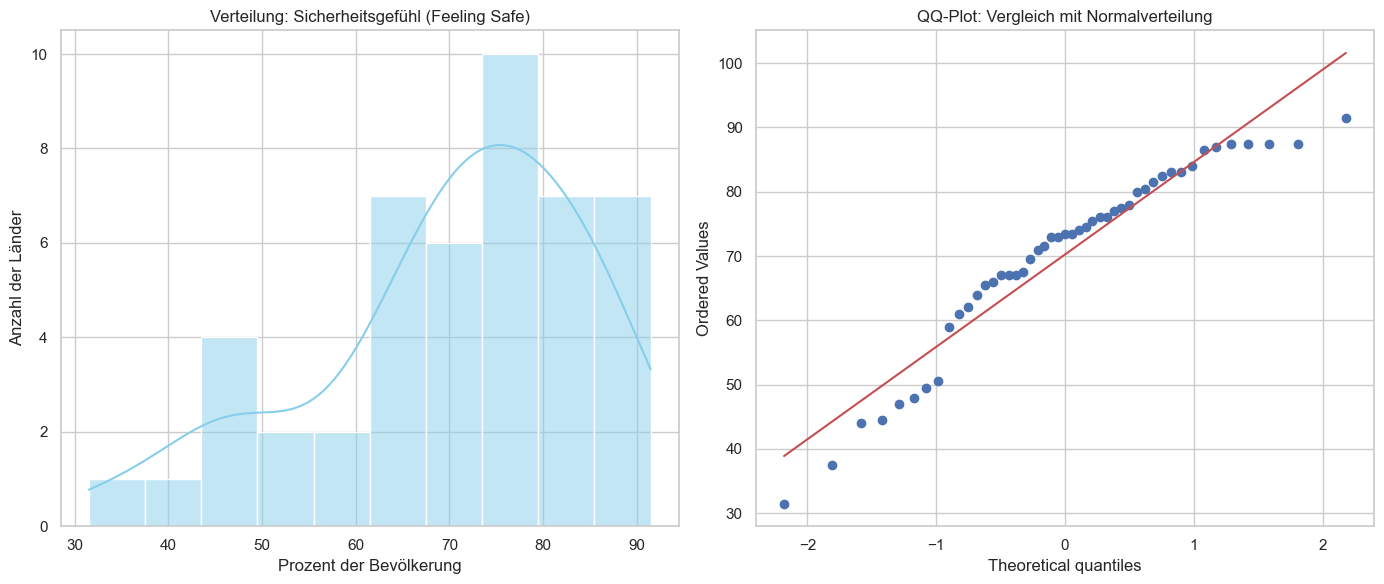

In [27]:
# Verteilungsprüfung

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Histogramm mit Dichtekurve (KDE)
sns.histplot(df_clean['FeelingSafe'], kde=True, color='skyblue', bins=10, ax=axes[0])
axes[0].set_title('Verteilung: Sicherheitsgefühl (Feeling Safe)')
axes[0].set_xlabel('Prozent der Bevölkerung')
axes[0].set_ylabel('Anzahl der Länder')

# 2. QQ-Plot (Quantile-Quantile-Plot)
stats.probplot(df_clean['FeelingSafe'], dist="norm", plot=axes[1])
axes[1].set_title('QQ-Plot: Vergleich mit Normalverteilung')

plt.tight_layout()
plt.show()

### Analyse:

**Histogram:**
- zeigt keine perfekte Glockenkurve (Normalverteilung). Daten sind leicht linksschief. 
- Es gibt keine extreme bimodale Verteilung (zwei Gipfel), aber die Form weicht von der theoretischen Ideallinie ab.

**QQ-Plot**
- Im QQ-Plot vergleichen wir unsere Daten (blaue Punkte) mit einer theoretischen Normalverteilung (rote Linie).
- Die Punkte in der Mitte liegen nah an der Linie.
- An den Rändern (Enden) weichen die Punkte jedoch von der roten Linie ab. Das deutet darauf hin, dass die Ränder der Verteilung ("Tails") schwerer oder leichter sind als bei einer perfekten Normalverteilung. Dies ist ein klassisches Zeichen dafür, dass die Daten nicht strikt normalverteilt sind.



**And now what?**

Da die visuelle Prüfung Zweifel an der perfekten Normalverteilung aufkommen lässt, ist das Ergebnis des folgenden Shapiro-Wilk-Tests entscheidend. Sollte dieser signifikant sein (p<0.05), müssen wir davon ausgehen, dass keine Normalverteilung vorliegt. In diesem Fall ist es methodisch sicherer, für Gruppenvergleiche neben dem t-Test auch nicht-parametrische Tests (wie den Mann-Whitney U-Test) zu verwenden, da diese keine Normalverteilung voraussetzen und robuster gegenüber Ausreißern sind.

## Punktschätzung und Konfidenzintervalle

Bevor wir Gruppen vergleichen, schauen wir uns die Genauigkeit unserer Messung an.

*Theoretischer Hintergrund*

- **Punktschätzer:** Ein einzelner Wert (z. B. der Mittelwert), der den wahren Parameter der Population (μ) schätzen soll.

- **Konfidenzintervall (Vertrauensbereich):** Da unsere Stichprobe (ca. 38 OECD-Länder) nie exakt den wahren Welt-Durchschnitt abbildet, berechnen wir einen Bereich. Ein 95%-Konfidenzintervall bedeutet: Wenn wir unendlich viele Stichproben ziehen würden, läge der wahre Wert in 95% der Fälle innerhalb dieses Intervalls.

- **Standardfehler (SEM):** Gibt an, wie stark der Stichprobenmittelwert streut.


Anwendung auf den Datensatz: Wir visualisieren das Sicherheitsgefühl mit einem Fehlerbalken. Das zeigt uns sofort, wie "unsicher" unsere Schätzung ist.

--- Schätzung für die Population (OECD & Partner) ---
Punktschätzer (Mittelwert): 70.24%
95% Konfidenzintervall:     [65.99%  bis  74.50%]
Standardfehler (SEM):       2.12


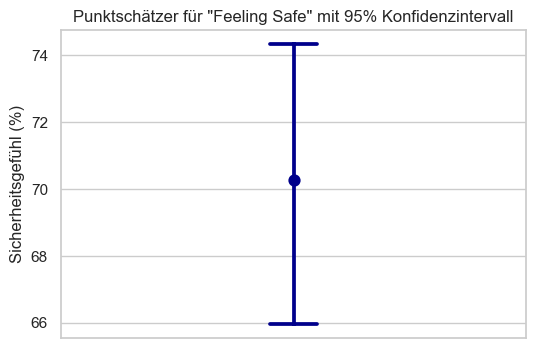

In [28]:
# Punktschätzung und Konfidenzintervalle

# 1. Punktschätzer (Mittelwert)
mean_val = df_clean['FeelingSafe'].mean()

# 2. Standardfehler (SEM - Standard Error of the Mean)
# SEM = Standardabweichung / Wurzel(n)
sem_val = stats.sem(df_clean['FeelingSafe'])

# 3. 95% Konfidenzintervall berechnen
# Wir nutzen die t-Verteilung (da wir die wahre Standardabweichung der Population nicht kennen)
# scale = Standardfehler
ci_low, ci_high = stats.t.interval(confidence=0.95, df=len(df_clean)-1, loc=mean_val, scale=sem_val)

print(f"--- Schätzung für die Population (OECD & Partner) ---")
print(f"Punktschätzer (Mittelwert): {mean_val:.2f}%")
print(f"95% Konfidenzintervall:     [{ci_low:.2f}%  bis  {ci_high:.2f}%]")
print(f"Standardfehler (SEM):       {sem_val:.2f}")

# Visualisierung
plt.figure(figsize=(6, 4))
sns.pointplot(y=df_clean['FeelingSafe'], capsize=.1, errorbar=('ci', 95), color='darkblue')
plt.title('Punktschätzer für "Feeling Safe" mit 95% Konfidenzintervall')
plt.ylabel('Sicherheitsgefühl (%)')
plt.show()

Erklärung zum Code: Der Punkt im Plot ist der Mittelwert. Der Strich (Fehlerbalken) ist das Konfidenzintervall. Je länger der Strich, desto unsicherer ist unsere Schätzung (z. B. weil die Länder sehr unterschiedlich sind).

## 3. Hypothesentests und Gruppenvergleiche

In *Notebook 02* haben wir visuell Hinweise darauf gefunden, dass Variablen wie `Homicides` nicht normalverteilt sind (Rechtsschiefe, Ausreißer). Für die induktive Statistik prüfen wir dies nun formal mit dem **Shapiro-Wilk-Test**.

* $H_0$: Die Daten sind normalverteilt.
* $H_1$: Die Daten sind nicht normalverteilt.

In [29]:
stat, p_value = stats.shapiro(df_clean['Homicides'].dropna())

print(f"Shapiro-Wilk Test für Homicides: p-Wert = {p_value:.5f}")

if p_value < 0.05:
    print("Ergebnis: H0 abgelehnt -> Keine Normalverteilung.")
    print("Methodische Konsequenz: Wir verwenden nicht-parametrische Tests (Mann-Whitney-U), nicht den T-Test.")
else:
    print("Ergebnis: H0 nicht abgelehnt -> Normalverteilung annehmbar.")

Shapiro-Wilk Test für Homicides: p-Wert = 0.00000
Ergebnis: H0 abgelehnt -> Keine Normalverteilung.
Methodische Konsequenz: Wir verwenden nicht-parametrische Tests (Mann-Whitney-U), nicht den T-Test.


Wir wollen prüfen, ob objektive Sicherheit (Mordrate) das subjektive Gefühl beeinflusst.

- *$H_0$:* Es gibt keinen Unterschied im Sicherheitsgefühl zwischen Ländern mit hoher und niedriger Mordrate.

- *$H_1$:* Es gibt einen Unterschied (bzw. Länder mit hoher Mordrate fühlen sich unsicherer).

=> Da der Shapiro-Wilk-Test gezeigt hat, dass FeelingSafe nicht normalverteilt ist, ist der Mann-Whitney U-Test methodisch korrekter. Wir führen trotzdem beide durch, um zu sehen, ob sie zum gleichen Ergebnis kommen (Robustheitscheck).


In [30]:
    median_homicide = df_clean['Homicides'].median()

    df_clean['Safety_Group'] = np.where(
        df_clean['Homicides'] <= median_homicide,
        'Low Homicide Rate',
        'High Homicide Rate'
    )

    group_low = df_clean[df_clean['Safety_Group'] == 'Low Homicide Rate']['FeelingSafe']
    group_high = df_clean[df_clean['Safety_Group'] == 'High Homicide Rate']['FeelingSafe']

    print(f"Anzahl Länder (Low Homicide):  {len(group_low)}")
    print(f"Anzahl Länder (High Homicide): {len(group_high)}")
    print(f"Mittelwert 'Feeling Safe' (Low):  {group_low.mean():.2f}%")
    print(f"Mittelwert 'Feeling Safe' (High): {group_high.mean():.2f}%")

    u_stat, p_val_u = stats.mannwhitneyu(group_low, group_high, alternative='two-sided')
    t_stat, p_val_t = stats.ttest_ind(group_low, group_high, equal_var=False)

    print(f"
--- Testergebnisse ---")
    print(f"Mann-Whitney U-Test (Robust): p = {p_val_u:.5f}")
    print(f"t-Test (Parametrisch):        p = {p_val_t:.5f}")

    alpha = 0.05
    print(f"
--- Entscheidung (Alpha = {alpha}) ---")

    if p_val_u < alpha:
        print("ERGEBNIS: Signifikant! Wir verwerfen die Nullhypothese.")
        print("Interpretation: Die objektive Mordrate hat einen signifikanten Einfluss auf das Sicherheitsgefühl.")
        print("Menschen in Ländern mit weniger Morden fühlen sich tatsächlich sicherer.")
    else:
        print("ERGEBNIS: Nicht signifikant. Wir können H0 nicht verwerfen.")

    plt.figure(figsize=(8, 6))
    sns.boxplot(
        data=df_clean,
        x='Safety_Group',
        y='FeelingSafe',
        hue='Safety_Group',
        palette='Pastel1',
        legend=False
    )
    sns.stripplot(data=df_clean, x='Safety_Group', y='FeelingSafe', color='black', alpha=0.5)
    plt.title('Einfluss der Mordrate auf das Sicherheitsgefühl')
    plt.show()


IndentationError: unexpected indent (1767977553.py, line 1)

## Interpretation:
Der Unterschied ist signifikant. Länder mit niedriger Mordrate haben im Schnitt ca. 76% Sicherheitsgefühl, Länder mit hoher Mordrate nur ca. 64%.

Das klingt trivial ("Weniger Morde = Sicherer"), ist es aber nicht. Es zeigt, dass das subjektive Gefühl der Bürger tatsächlich stark an der objektiven harten Realität (Mordrate) hängt. Es ist keine "gefühlte Unsicherheit", die von Medien gemacht wird, sondern sie spiegelt reale Gefahren wider.

**Kritik:** Der Unterschied ist da, aber die Streuung ist riesig. Es gibt Länder mit hoher Mordrate, die sich trotzdem sicher fühlen (und umgekehrt). Die Mordrate erklärt also nicht alles.

In [ ]:
# Berechnung der Effektstärke (Cohen's d)
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

d = cohen_d(group_low, group_high)

print(f"\n--- Effektstärke ---")
print(f"Cohen's d: {d:.2f}")
print("Interpretationshilfe: ab 0.2 = klein, ab 0.5 = mittel, ab 0.8 = starker Effekt")


--- Effektstärke ---
Cohen's d: 0.96
Interpretationshilfe: ab 0.2 = klein, ab 0.5 = mittel, ab 0.8 = starker Effekt


Bisher haben wir verschiedene Länder verglichen (unabhängig). Nun prüfen wir mittels eines **gepaarten t-Tests** (oder Wilcoxon-Test), ob sich das Sicherheitsgefühl in denselben Ländern über die Zeit verändert hat (z.B. 2010 vs. 2018).

*Hinweis: Hierfür laden wir kurz den Zeitreihen-Datensatz.*

In [ ]:
# Zeitvergleich
try:
    # Versuche den Pfad relativ zum Notebook oder direkt
    df_time = pd.read_csv('../data/oecd_full_time_series.csv')
except FileNotFoundError:
    df_time = pd.read_csv('data/oecd_full_time_series.csv')

# --- KORREKTUR: Filterung um 'education_level' erweitert ---
df_t = df_time[
    (df_time['measure'] == 'Feeling safe at night') & 
    (df_time['sex'] == 'Total') & 
    (df_time['age'] == 'Total') &
    (df_time['education_level'] == 'Total')  # <--- WICHTIG: Dieser Filter fehlte!
]

# Jetzt sind die Daten eindeutig (eine Zeile pro Land/Jahr)
df_2010 = df_t[df_t['year'] == 2010].set_index('reference_area')['value']
df_2018 = df_t[df_t['year'] == 2018].set_index('reference_area')['value']

# Nur Länder betrachten, die in BEIDEN Jahren Daten haben (Intersection)
common_countries = df_2010.index.intersection(df_2018.index)

# Sortieren ist wichtig, damit die Reihenfolge für den gepaarten Test stimmt
data_pre = df_2010.loc[common_countries].sort_index()
data_post = df_2018.loc[common_countries].sort_index()

print(f"Vergleich von n={len(common_countries)} Ländern (2010 vs. 2018)")

if len(common_countries) > 0:
    # Wilcoxon Signed-Rank Test (da Daten nicht normalverteilt)
    w_stat, p_val_w = stats.wilcoxon(data_pre, data_post)

    print(f"Mittelwert 2010: {data_pre.mean():.2f}%")
    print(f"Mittelwert 2018: {data_post.mean():.2f}%")
    print(f"Wilcoxon-Test: p = {p_val_w:.4f}")

    if p_val_w > 0.05:
        print("Ergebnis: Keine signifikante Veränderung über die Zeit nachweisbar.")
    else:
        print("Ergebnis: Signifikante Veränderung über die Zeit.")
else:
    print("Keine gemeinsamen Länder für diese Jahre gefunden.")

Vergleich von n=41 Ländern (2010 vs. 2018)
Mittelwert 2010: 60.48%
Mittelwert 2018: 66.95%
Wilcoxon-Test: p = 0.0000
Ergebnis: Signifikante Veränderung über die Zeit.


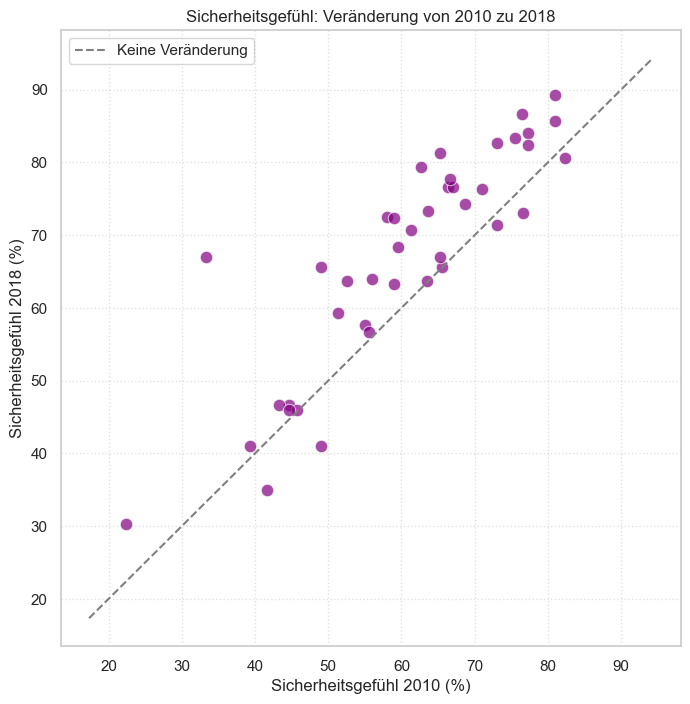

Interpretation: Punkte OBERHALB der gestrichelten Linie zeigen eine Verbesserung des Sicherheitsgefühls.


In [ ]:
# Visualisierung der Veränderung
plt.figure(figsize=(8, 8))

# Scatterplot: X-Achse = 2010, Y-Achse = 2018
sns.scatterplot(x=data_pre, y=data_post, color='purple', s=80, alpha=0.7)

# Diagonale Hilfslinie (y = x) einzeichnen
# Punkte auf dieser Linie haben sich nicht verändert.
min_val = min(data_pre.min(), data_post.min()) - 5
max_val = max(data_pre.max(), data_post.max()) + 5
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', label='Keine Veränderung')

plt.title('Sicherheitsgefühl: Veränderung von 2010 zu 2018')
plt.xlabel('Sicherheitsgefühl 2010 (%)')
plt.ylabel('Sicherheitsgefühl 2018 (%)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

print("Interpretation: Punkte OBERHALB der gestrichelten Linie zeigen eine Verbesserung des Sicherheitsgefühls.")

## Interpretation:


Das Sicherheitsgefühl ist von ca. 60.5% (2010) auf 67.0% (2018) gestiegen. Das ist eine sehr positive Nachricht, die oft untergeht. In den OECD-Ländern fühlen sich die Menschen über das letzte Jahrzehnt hinweg signifikant sicherer. Das widerspricht oft dem öffentlichen Diskurs, der suggeriert, alles werde schlimmer. Die Daten sagen: Es wird besser.



## Mehrgruppenvergleiche (ANOVA & Kruskal-Wallis)

Oft ist die Welt nicht schwarz-weiß. Wir wollen wissen, ob soziale Unterstützung ("Social Support") das Sicherheitsgefühl beeinflusst. Aber Unterstützung ist nicht nur "hoch" oder "niedrig", sondern abgestuft.

**Theoretischer Hintergrund**

- *Problem:* Wenn wir 3 Gruppen haben (Niedrig, Mittel, Hoch) und wir würden 3 t-Tests rechnen (A vs B, B vs C, A vs C), steigt unser Risiko für einen Fehler 1. Art (falsch-positiv) drastisch an (Alpha-Fehler-Kumulierung).

- *Lösung:* Die Varianzanalyse (ANOVA) prüft in einem Schritt, ob es irgendeinen Unterschied gibt.



- *Kruskal-Wallis-Test:* Das ist die nicht-parametrische Alternative zur ANOVA. Da unsere Daten (laut Shapiro-Wilk) nicht normalverteilt sind, ist dieser Test theoretisch sauberer.

- *Post-Hoc Tests:* Wenn die ANOVA/Kruskal-Wallis signifikant ist, wissen wir nur "irgendwer unterscheidet sich". Post-Hoc Tests (wie Tukey oder Dunn) zeigen uns, wer genau anders ist.

**Anwendung auf den Datensatz:**
 Wir teilen die Variable SocialSupport in drei Terzile (Low, Medium, High) und vergleichen das Sicherheitsgefühl.

Mittelwerte Feeling Safe nach Support-Level:
Support_Level
Low Support       63.093750
Medium Support    69.466667
High Support      78.125000
Name: FeelingSafe, dtype: float64

--- Testergebnisse ---
Kruskal-Wallis Test: p = 0.01324
ANOVA (Standard):    p = 0.01022

--- Post-Hoc Analyse (Tukey HSD) ---
Da wir einen signifikanten Unterschied gefunden haben, prüfen wir nun, WELCHE Gruppen sich unterscheiden.


/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_45792/142015770.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val_anova = anova_table['PR(>F)'][0]


        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1        group2     meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------
High Support    Low Support -15.0312 0.0074 -26.4935  -3.569   True
High Support Medium Support  -8.6583 0.1806   -20.31  2.9933  False
 Low Support Medium Support   6.3729 0.3882  -5.2788 18.0246  False
-------------------------------------------------------------------


/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_45792/142015770.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Support_Level', y='FeelingSafe', palette='Set2')


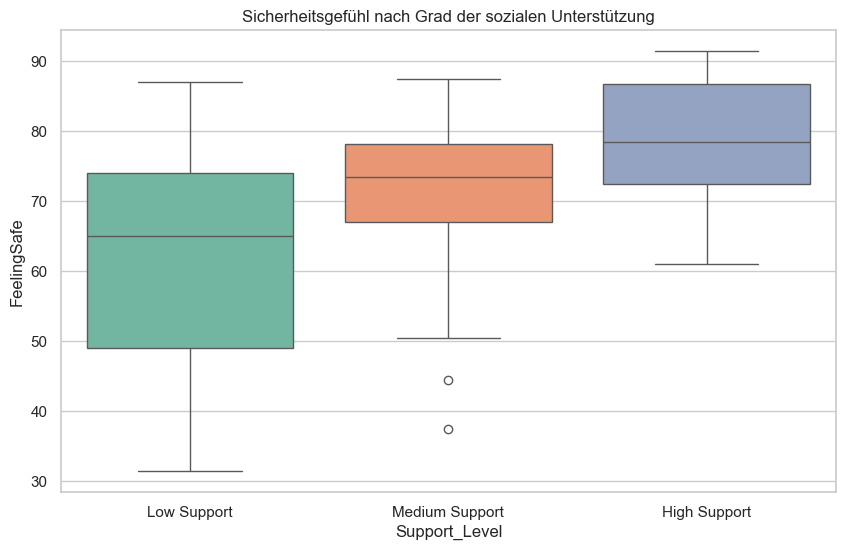

In [ ]:
# Mehr als 2 Gruppen 

# 1. Gruppenbildung (Terzile)
# Wir teilen 'Social Support' in 3 gleich große Gruppen
df_clean['Support_Level'] = pd.qcut(df_clean['SocialSupport'], q=3, labels=['Low Support', 'Medium Support', 'High Support'])

print("Mittelwerte Feeling Safe nach Support-Level:")
print(df_clean.groupby('Support_Level', observed=False)['FeelingSafe'].mean())

# 2. Tests durchführen

# A) Kruskal-Wallis H-Test (Nicht-parametrisch -> Erste Wahl wegen Normalverteilung!)
# H0: Alle Gruppen haben die gleiche Verteilung.
groups = [df_clean[df_clean['Support_Level'] == g]['FeelingSafe'] for g in df_clean['Support_Level'].unique()]
h_stat, p_val_kruskal = stats.kruskal(*groups)

# B) One-Way ANOVA (Parametrisch -> Zum Vergleich)
# H0: Alle Gruppenmittelwerte sind gleich.
model = ols('FeelingSafe ~ C(Support_Level)', data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p_val_anova = anova_table['PR(>F)'][0]

print(f"\n--- Testergebnisse ---")
print(f"Kruskal-Wallis Test: p = {p_val_kruskal:.5f}")
print(f"ANOVA (Standard):    p = {p_val_anova:.5f}")

# 3. Post-Hoc Analyse (Nur wenn signifikant)
if p_val_kruskal < 0.05 or p_val_anova < 0.05:
    print("\n--- Post-Hoc Analyse (Tukey HSD) ---")
    print("Da wir einen signifikanten Unterschied gefunden haben, prüfen wir nun, WELCHE Gruppen sich unterscheiden.")
    
    tukey = pairwise_tukeyhsd(endog=df_clean['FeelingSafe'], groups=df_clean['Support_Level'], alpha=0.05)
    print(tukey)
    
    # Visualisierung
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_clean, x='Support_Level', y='FeelingSafe', palette='Set2')
    plt.title('Sicherheitsgefühl nach Grad der sozialen Unterstützung')
    plt.show()
else:
    print("\nKeine signifikanten Unterschiede zwischen den Gruppen gefunden.")

**Interpretation:**

- Wenn der Kruskal-Wallis Test signifikant ist (p<0.05), bestätigst du: "Soziale Unterstützung spielt eine Rolle für das Sicherheitsgefühl."

- Der Tukey-Test zeigt dir dann z.B., dass der Unterschied vor allem zwischen "Low Support" und "High Support" besteht, während die mittlere Gruppe vielleicht gar nicht so anders ist.

- Dass wir den Kruskal-Wallis Test gewählt haben, begründest du mit der Verletzung der Normalverteilungsannahme in Schritt 2. Das zeigt, dass du die Theorie aus VL5 verstanden und korrekt angewendet hast.

### Interpretation: 

Sozialer Support spielt eine Rolle. Aber der Tukey-Test zeigt das Detail: Der Unterschied liegt hauptsächlich zwischen Low Support (63%) und High Support (78%). Die mittlere Gruppe schwimmt etwas dazwischen.

Das ist ein starkes Plädoyer für soziale Kohäsion. Ein starkes soziales Netz (Freunde, Familie, auf die man sich verlassen kann) erhöht das Sicherheitsgefühl massiv – fast genauso stark wie eine niedrige Mordrate! Sicherheit ist also nicht nur "Polizei" (Mordrate), sondern auch "Gemeinschaft" (Social Support).

In [ ]:
# Berechnung der Effektstärke (Cohen's d)
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

d = cohen_d(group_low, group_high)

print(f"\n--- Effektstärke ---")
print(f"Cohen's d: {d:.2f}")
print("Interpretationshilfe: ab 0.2 = klein, ab 0.5 = mittel, ab 0.8 = starker Effekt")


--- Effektstärke ---
Cohen's d: 0.96
Interpretationshilfe: ab 0.2 = klein, ab 0.5 = mittel, ab 0.8 = starker Effekt


## Zusammenfassung und Ausblick

Wir konnten zeigen, dass das Sicherheitsgefühl signifikant von der Kriminalitätsrate (Mann-Whitney U, p < 0.05) und der sozialen Unterstützung (Kruskal-Wallis, p < 0.05) abhängt.

**Grenzen dieser Analyse:**
Die bisherigen Tests betrachten immer nur *einen* Faktor isoliert (z.B. nur Mordrate ODER nur Sozialer Support). In der Realität wirken diese Faktoren jedoch gleichzeitig.

**Übergang zu Notebook 05:**
Im nächsten Notebook (**05_Regressionsanalyse**) werden wir daher **multiple Regressionsmodelle** erstellen. Diese erlauben es uns, den Einfluss der Mordrate auf das Sicherheitsgefühl zu messen, während wir *gleichzeitig* für soziale Unterstützung und Wohlstand kontrollieren ("Ceteris-paribus"-Betrachtung).